# **Projet Python pour la Data Science**
### **Modélisation des valeurs du CAC40 à partir des politiques de la BCE**
##### **Carla LUCAS, Amrei LYTIN, Alban NELIAS**

Dans ce projet Python pour la Data Science, nous cherchons à produire un modèle de prédiction des valeurs du CAC40, en fonction de données économiques (PIB, chômage, inflation, confiance...) et des politiques de la Banque Centrale Européenne. 

Notre travail s'est décliné en plusieurs étapes : 

- Définir nos variables explicatives, les importer depuis Internet grâce à leur URL
- Nettoyer ces données pour les rendre exploitables
- Analyser ces données
- Trouver le modèle pertinent pour expliquer l'influence des variables sur les valeurs du CAC40

## **Sommaire**

- [Installation](#Installation)
- [Récupération des données](#Récupération-des-données)
- [Nettoyage des données](#Nettoyage-des-données)
- [Analyse des données](#Analyse-des-données)
- [Modélisations](#Modélisation)
    - [Modélisation du CAC 40 à partir des variables macroéconomiques](#Modélisation-du-CAC-40-à-partir-des-variables-macroéconomiques)
    - [Modélisation des effets des politiques monétaires sur le CAC 40](#Modélisation-des-effets-des-politiques-monétaires-sur-le-CAC-40)
- [Résultats et conclusion](#Résultats-et-conclusion)

## **Installation** 
Importation des libraries et installation des modules nécessaires.


In [26]:
import pandas as pd
pd.set_option('display.max_columns', 5)  # Limite l'affichage à 5 colonnes
import numpy as np
import os
import requests
import zipfile
import requests
import zipfile
import nettoyage as nt
import recuperation as rc
import analyse as an

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
from io import BytesIO

In [27]:
!pip install --upgrade scikit-learn
!pip install openpyxl
!pip install yfinance
!pip install jupyter_contrib_nbextensions

## **Récupération des données**

### **Données du CAC 40**
Nous utilisons l'API yfinance afin de récupérer les données et les rassembler dans un fichier CSV.

In [28]:
import yfinance as yf

CAC40_y = "^FCHI"  
dfcac40 = yf.download(CAC40_y, start="2000-01-01", interval="3mo")

dfcac40.to_csv("cac40_trimestre.csv")
cac40 = pd.read_csv("cac40_trimestre.csv")

[*********************100%***********************]  1 of 1 completed


### **Données de la BCE** 
##### **Nous téléchargons le csv depuis l'url suivante.**

https://data.ecb.europa.eu/data/datasets/FM/FM.B.U2.EUR.4F.KR.MRR_FR.LEV?chart_props=W3sibm9kZUlkIjoiMzQ2NTY5IiwicHJvcGVydGllcyI6W3siY29sb3JIZXgiOiIiLCJjb2xvclR5cGUiOiIiLCJjaGFydFR5cGUiOiJsaW5lY2hhcnQiLCJsaW5lU3R5bGUiOiJTb2xpZCIsImxpbmVXaWR0aCI6IjEuNSIsImF4aXNQb3NpdGlvbiI6ImxlZnQiLCJvYnNlcnZhdGlvblZhbHVlIjpmYWxzZSwiZGF0ZXMiOltdLCJpc1RkYXRhIjpmYWxzZSwibW9kaWZpZWRVbml0VHlwZSI6IiIsInllYXIiOiJmdWxsUmFuZ2UiLCJzdGFydERhdGUiOiIxOTk5LTAxLTAxIiwiZW5kRGF0ZSI6IjIwMjQtMTItMTgiLCJzZXREYXRlIjp0cnVlLCJzaG93VGFibGVEYXRhIjpmYWxzZSwiY2hhbmdlTW9kZSI6ZmFsc2UsInNob3dNZW51U3R5bGVDaGFydCI6ZmFsc2UsImRpc3BsYXlNb2JpbGVDaGFydCI6dHJ1ZSwic2NyZWVuU2l6ZSI6Im1heCIsInNjcmVlbldpZHRoIjoxNDQwLCJzaG93VGRhdGEiOmZhbHNlLCJ0cmFuc2Zvcm1lZEZyZXF1ZW5jeSI6Im5vbmUiLCJ0cmFuc2Zvcm1lZFVuaXQiOiJub25lIiwiZnJlcXVlbmN5Ijoibm9uZSIsInVuaXQiOiJub25lIiwibW9kaWZpZWQiOiJmYWxzZSIsInNlcmllc0tleSI6ImRhaWx5IC0gYnVzaW5lc3N3ZWVrIiwic2hvd3RhYmxlU3RhdGVCZWZvcmVNYXhTY3JlZW4iOmZhbHNlLCJpc2RhdGFjb21wYXJpc29uIjpmYWxzZSwic2VyaWVzRnJlcXVlbmN5IjoiZGFpbHkgLSBidXNpbmVzc3dlZWsiLCJpbnRpYWxTZXJpZXNGcmVxdWVuY3kiOiJkYWlseSAtIGJ1c2luZXNzd2VlayIsIm1ldGFkYXRhRGVjaW1hbCI6IjQiLCJpc1RhYmxlU29ydGVkIjpmYWxzZSwiaXNZZWFybHlUZGF0YSI6ZmFsc2UsInJlc3BvbnNlRGF0YUVuZERhdGUiOiIiLCJpc2luaXRpYWxDaGFydERhdGEiOnRydWUsImlzRGF0ZXNGcm9tRGF0ZVBpY2tlciI6dHJ1ZSwiZGF0ZVBpY2tlckVuZERhdGUiOiIiLCJpc0RhdGVQaWNrZXJFbmREYXRlIjpmYWxzZSwic2VyaWVza2V5U2V0IjoiIiwiZGF0YXNldElkIjoiNjciLCJpc0NhbGxiYWNrIjpmYWxzZSwiaXNTbGlkZXJUZGF0YSI6dHJ1ZSwiaXNTbGlkZXJEYXRhIjp0cnVlLCJpc0luaXRpYWxDaGFydERhdGFGcm9tR3JhcGgiOnRydWUsImNoYXJ0U2VyaWVzS2V5IjoiRk0uQi5VMi5FVVIuNEYuS1IuTVJSX0ZSLkxFViIsInR5cGVPZiI6IiJ9XX1d

### **Variables macroéconomiques**
Nous récupérons les données sur internet à partir des liens URL des sites hébergeant les données. 

In [29]:
chomage = rc.url_df("https://www.insee.fr/fr/statistiques/fichier/2532173/econ-gen-taux-cho-trim-2.xlsx", None, None, save_as_csv=True, csv_name="chomage.csv")
confiance = rc.url_df("https://www.insee.fr/en/statistiques/serie/telecharger/xlsx/001587668?ordre=antechronologique&transposition=donneesligne&periodeDebut=10&anneeDebut=1972&periodeFin=11&anneeFin=2024&revision=sansrevisions", None, None, save_as_csv=True, csv_name="confiance.csv")
ev_pib = rc.url_df("https://www.insee.fr/fr/statistiques/fichier/2830547/econ-gen-pib-composante-trim.xlsx", None, None, save_as_csv=True, csv_name="ev_pib.csv")
ipc = rc.url_df("https://www.insee.fr/fr/statistiques/serie/telecharger/xlsx/001759970?ordre=antechronologique&transposition=donneescolonne&periodeDebut=1&anneeDebut=1990&periodeFin=11&anneeFin=2024&revision=sansrevisions", None, None, save_as_csv=True, csv_name="ipc.csv")

Le fichier téléchargé est un fichier Excel.
Feuille non spécifiée, chargement de : Données
Feuille 'Données' chargée.
Fichier sauvegardé au format CSV sous le nom : chomage.csv
Le fichier téléchargé est un fichier zip.
Fichier Excel non spécifié, utilisation de : serie_001587668_29122024.xlsx.
Feuille non spécifiée, chargement de : monthly_values
Feuille 'monthly_values' chargée.
Fichier sauvegardé au format CSV sous le nom : confiance.csv
Le fichier téléchargé est un fichier Excel.
Feuille non spécifiée, chargement de : Données


/opt/conda/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Feuille 'Données' chargée.
Fichier sauvegardé au format CSV sous le nom : ev_pib.csv
Le fichier téléchargé est un fichier zip.
Fichier Excel non spécifié, utilisation de : serie_001759970_29122024.xlsx.
Feuille non spécifiée, chargement de : valeurs_mensuelles
Feuille 'valeurs_mensuelles' chargée.
Fichier sauvegardé au format CSV sous le nom : ipc.csv


/opt/conda/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [30]:


test = rc.url_df("https://www.insee.fr/fr/statistiques/fichier/2532173/econ-gen-taux-cho-trim-2.xlsx", None, None, save_as_csv=True, csv_name="chomage.csv")

Le fichier téléchargé est un fichier Excel.
Feuille non spécifiée, chargement de : Données
Feuille 'Données' chargée.
Fichier sauvegardé au format CSV sous le nom : chomage.csv


## **Nettoyage des données**

Nous avons automatisé autant de fonctions de nettoyage que possible, mais étant donné que toutes les bases de données sont différentes, nous avons surtout procédé à un nettoyage personnalisé pour chaque cas.

### **Nettoyage des données sur le CAC 40**

Nous cherchons à éliminer les données inutile à notre analyse. Pour cela, nous ouvrons la base de données et nettoyons les colonnes. Nous avons décidé de conserver seulement la colonne Close de l'indicateur trimestriel du CAC 40. 

In [31]:
cac40.head()

,Price,Close,...,Open,Volume
0,Ticker,^FCHI,...,^FCHI,^FCHI
1,Date,NaN,...,NaN,NaN
2,1999-12-01,6190.9599609375,...,6024.3798828125,0
3,2000-03-01,6426.259765625,...,6272.1298828125,0
4,2000-06-01,6625.419921875,...,6428.4599609375,0


In [32]:
cac40.drop(columns=['Volume', 'High', 'Low', 'Open'], inplace=True)
cac40 = cac40.iloc[3:].reset_index(drop=True)
cac40.rename(columns={'Price': 'trimestre'}, inplace=True)
nt.handle_missing_values(cac40)

cac40['trimestre'] = pd.to_datetime(cac40['trimestre'])
# Création du format 2000.T1, 2000.T2...
cac40['trimestre'] = cac40['trimestre'].dt.year.astype(str) + '.T' + ((cac40['trimestre'].dt.month - 1) // 3 + 1).astype(str)

cac40['Close'] = pd.to_numeric(cac40['Close'], errors='coerce')


### **Nettoyage des données sur le chômage**

In [33]:
chomage.head()

,Taux de chômage selon le sexe et l'âge,Unnamed: 1,...,Unnamed: 198,Unnamed: 199
0,NaN,NaN,...,NaN,NaN
1,en %,NaN,...,NaN,NaN
2,Sexe et âge,1975-T1,...,2024-T2,2024-T3
3,Femmes,4.6,...,7.4,7.2
4,15-24 ans,9.8,...,18.2,20


In [34]:
chomage = chomage.T
chomage = chomage[[2, 11]]
chomage.columns = chomage.iloc[0] 
chomage = chomage[1:]
chomage.rename(columns={"Sexe et âge": "trimestre", "Ensemble ": "taux_chomage"}, inplace=True)
chomage['trimestre'] = chomage['trimestre'].str.replace('-', '.', regex=False)
chomage.columns = ["trimestre", "taux_chomage"]
chomage = chomage.reset_index(drop=True)
nt.handle_missing_values(chomage)
nt.filter_dataframe_by_trimestre(chomage, "2000.T1")

,trimestre,taux_chomage
0,2000.T1,9.1
1,2000.T2,8.7
2,2000.T3,8.4
3,2000.T4,8
4,2001.T1,7.8
...,...,...
94,2023.T3,7.4
95,2023.T4,7.5
96,2024.T1,7.5
97,2024.T2,7.3


### **Nettoyage des données sur la confiance**


In [35]:
confiance

,Label,idBank,...,1972-11,1972-10
0,Monthly consumer confidence survey - Summary i...,1587668,...,128,127


In [36]:
# Suppression des colonnes inutiles
confiance.drop(columns=["Label","idBank", "Last update", "Period"])

# On transpose pour travailler sur les index
conf_transpose = confiance.T
conf_transpose.columns = ['Value'] 

# On exclue les valeurs qui ne respectent pas le format AAAA-MM
conf_transpose = conf_transpose[conf_transpose.index.str.match(r'^\d{4}-\d{2}$')]

# On extrait l'année et le mois depuis l'index
conf_transpose['Annee'] = conf_transpose.index.str[:4].astype(int)
conf_transpose['Mois'] = conf_transpose.index.str[-2:].astype(int)

# Création d'une colonne pour le trimestre
conf_transpose['TrimAnnee'] = ((conf_transpose['Mois'] - 1) // 3) + 1

# Calcul des moyennes trimestrielles en groupant par année et trimestre
TrimAnnee_Moyen = (
    conf_transpose
    .groupby(['Annee', 'TrimAnnee'])['Value']
    .mean()
    .reset_index()
)

# Créeation d'un dataframe avec nos données
TrimAnnee_Moyen['trimestre'] = TrimAnnee_Moyen['Annee'].astype(str) + '.T' + TrimAnnee_Moyen['TrimAnnee'].astype(str)
confiance = TrimAnnee_Moyen[['trimestre', 'Value']].rename(columns={'Value': 'indic_confiance'})
confiance


,trimestre,indic_confiance
0,1972.T4,128.0
1,1973.T1,130.333333
2,1973.T2,130.333333
3,1973.T3,126.0
4,1973.T4,122.0
...,...,...
204,2023.T4,87.666667
205,2024.T1,90.666667
206,2024.T2,90.0
207,2024.T3,92.666667


In [37]:
nt.filter_dataframe_by_trimestre(confiance, "2000.T1")
nt.handle_missing_values(confiance)

,trimestre,indic_confiance
0,1972.T4,128.0
1,1973.T1,130.333333
2,1973.T2,130.333333
3,1973.T3,126.0
4,1973.T4,122.0
...,...,...
204,2023.T4,87.666667
205,2024.T1,90.666667
206,2024.T2,90.0
207,2024.T3,92.666667


### **Nettoyage des données sur le PIB**


On cherche à isoler des indicateurs pour l'évolution du PIB, la consommation des ménages et des APU, la formation brute de capital fixe, les importations et exportations. On fait le choix de prendre plus d'indicateurs, quitte à les éliminer par la suite.

In [38]:
ev_pib

,Évolution du produit intérieur brut et de ses composantes,Unnamed: 1,...,Unnamed: 11,Unnamed: 12
0,NaN,NaN,...,NaN,NaN
1,par rapport au trimestre précédent en volume en %,NaN,...,NaN,NaN
2,Trimestre,Produit intérieur brut (PIB),...,NaN,NaN
3,NaN,NaN,...,Variations de stocks,Commerce extérieur
4,2024-T3,0.38673,...,0.134889,-0.053171
...,...,...,...,...,...
306,1. Administrations publiques.,NaN,...,NaN,NaN
307,Note : données révisées ; les volumes sont mes...,NaN,...,NaN,NaN
308,"Lecture : au 3e trimestre 2024, le produit int...",NaN,...,NaN,NaN
309,Champ : France.,NaN,...,NaN,NaN


In [39]:
ev_pib.columns = ev_pib.iloc[2] 
ev_pib = ev_pib[["Trimestre", "Produit intérieur brut (PIB)", "Importations", "Dépense de consommation des ménages", "Dépense de consommation des APU1", "Formation brute de capital fixe", "Exportations" ]]
ev_pib = ev_pib.drop(index=range(0,4))
ev_pib = ev_pib.drop(index=range(306,311))

# Renommer les colonnes à utiliser
ev_pib.rename(columns={'Trimestre': 'trimestre'}, inplace=True)
ev_pib.rename(columns={'Produit intérieur brut (PIB)': 'ev_pib'}, inplace=True) 
ev_pib.rename(columns={'Importations': 'ev_importations'}, inplace=True) 
ev_pib.rename(columns={'Dépense de consommation des ménages': 'ev_conso_menages'}, inplace=True) 
ev_pib.rename(columns={'Dépense de consommation des APU1': 'ev_conso_apu'}, inplace=True) 
ev_pib.rename(columns={'Formation brute de capital fixe': 'ev_fbcf'}, inplace=True) 
ev_pib.rename(columns={'Exportations': 'ev_exportations'}, inplace=True) 
ev_pib['trimestre'] = ev_pib['trimestre'].str.replace('-', '.', regex=False)

#Création d'une variable consommation regroupant la consommation des APU et des ménages
ev_pib['ev_conso'] = ev_pib['ev_conso_menages'] + ev_pib['ev_conso_apu']

#Inversion des colonnes pour avoir des données chronologiques et sélection depuis le premier trimestre de l'année 2000
ev_pib = ev_pib.iloc[::-1].reset_index(drop=True)
nt.handle_missing_values(ev_pib)

2,trimestre,ev_pib,...,ev_exportations,ev_conso
0,1949.T2,0.901743,...,2.978648,1.448613
1,1949.T3,1.49785,...,0.761173,3.298319
2,1949.T4,1.397159,...,2.231508,1.284711
3,1950.T1,2.748324,...,8.074533,3.774419
4,1950.T2,2.525426,...,3.479008,4.10811
...,...,...,...,...,...
297,2023.T3,0.050172,...,-0.921628,1.062594
298,2023.T4,0.447218,...,0.705229,0.742375
299,2024.T1,0.208671,...,0.537697,0.766329
300,2024.T2,0.184356,...,0.63906,0.518293


In [40]:
nt.filter_dataframe_by_trimestre(ev_pib, "2000.T1")

2,trimestre,ev_pib,...,ev_exportations,ev_conso
0,2000.T1,0.983261,...,2.840179,1.861406
1,2000.T2,1.06689,...,4.95979,1.239539
2,2000.T3,0.781831,...,1.415566,0.787557
3,2000.T4,0.562298,...,2.986463,0.285783
4,2001.T1,0.576989,...,0.403586,1.264287
...,...,...,...,...,...
94,2023.T3,0.050172,...,-0.921628,1.062594
95,2023.T4,0.447218,...,0.705229,0.742375
96,2024.T1,0.208671,...,0.537697,0.766329
97,2024.T2,0.184356,...,0.63906,0.518293


### **Nettoyage des données sur l'indice des prix à la consommation**


In [41]:
ipc

,Libellé,Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble,Unnamed: 2
0,idBank,001759970,NaN
1,Dernière mise à jour,13/12/2024 08:45,NaN
2,Période,NaN,Date de parution au JO
3,2024-11,119.72,15/12/2024
4,2024-10,119.89,17/11/2024
...,...,...,...
417,1990-05,67.19,29/06/1990
418,1990-04,67.09,01/06/1990
419,1990-03,66.72,02/05/1990
420,1990-02,66.56,30/03/1990


In [42]:
ipc = ipc[["Libellé", "Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble"]]
ipc.rename(columns={'Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble': 'ipc_menage'}, inplace=True) 
ipc = ipc.drop(index=range(0,3))
ipc = ipc.iloc[::-1].reset_index(drop=True)

# On extrait l'année et le mois
ipc['Année'] = ipc['Libellé'].str[:4].astype(int)
ipc['Mois'] = ipc['Libellé'].str[5:].astype(int)

# On détermine le trimestre
ipc['trimestre'] = ((ipc['Mois'] - 1) // 3) + 1

# Calcul de la moyenne trimestrielle
ipc['trimestre'] = ipc['Année'].astype(str) + '.T' + ipc['trimestre'].astype(str)
ipc = ipc.groupby('trimestre')['ipc_menage'].mean().reset_index()
nt.handle_missing_values(ipc)

/tmp/ipykernel_34528/1612128764.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ipc.rename(columns={'Indice des prix à la consommation - Base 2015 - Ensemble des ménages - France - Ensemble': 'ipc_menage'}, inplace=True)


,trimestre,ipc_menage
0,1990.T1,66.566667
1,1990.T2,67.153333
2,1990.T3,67.653333
3,1990.T4,68.33
4,1991.T1,68.803333
...,...,...
135,2023.T4,118.35
136,2024.T1,118.956667
137,2024.T2,120.126667
138,2024.T3,120.346667


In [43]:
nt.filter_dataframe_by_trimestre(ipc, "2000.T1")

,trimestre,ipc_menage
0,2000.T1,79.36
1,2000.T2,79.813333
2,2000.T3,80.106667
3,2000.T4,80.436667
4,2001.T1,80.396667
...,...,...
95,2023.T4,118.35
96,2024.T1,118.956667
97,2024.T2,120.126667
98,2024.T3,120.346667


### **Création d'une base de données contenant toutes les données**
On veut à présent rassembler toutes les données dans un seul tableau indexé par la date en trimestre depuis 2000.

In [44]:
chomage = chomage[chomage['trimestre'].str.startswith('20')]
ipc = ipc[ipc['trimestre'].str.startswith('20')]
ev_pib = ev_pib[ev_pib['trimestre'].str.startswith('20')]
confiance = confiance[confiance['trimestre'].str.startswith('20')]
cac40 = cac40[cac40['trimestre'].str.startswith('20')]

In [45]:
chomage['trimestre'] = chomage['trimestre'].str.strip()

In [ ]:
# Fusionner toutes les données dans un seul dataframe
dfs = [cac40, chomage, confiance, ev_pib, ipc]  
df = dfs[0]  # Initialisation avec le premier dataframe

for other_df in dfs[1:]:
    df = df.merge(other_df, on="trimestre", how="outer") 

df.set_index('trimestre', inplace=True)
df = df.iloc[:-1]

,Close,taux_chomage,...,ev_conso,ipc_menage
trimestre,,,,,
2000.T1,6426.259766,9.1,...,1.861406,79.36
2000.T2,6625.419922,8.7,...,1.239539,79.813333
2000.T3,5928.080078,8.4,...,0.787557,80.106667
2000.T4,5367.479980,8,...,0.285783,80.436667
2001.T1,5454.189941,7.8,...,1.264287,80.396667
...,...,...,...,...,...
2023.T3,7310.770020,7.4,...,1.062594,118.286667
2023.T4,7927.430176,7.5,...,0.742375,118.35
2024.T1,7992.870117,7.5,...,0.766329,118.956667


## **Analyse des données**

### **L'indicateur de fermeture du CAC 40**


Tableau des statistiques :

  Statistique        Valeur
0     Moyenne  4.865332e+03
1  Écart-type  1.260782e+03
2    Variance  1.589571e+06


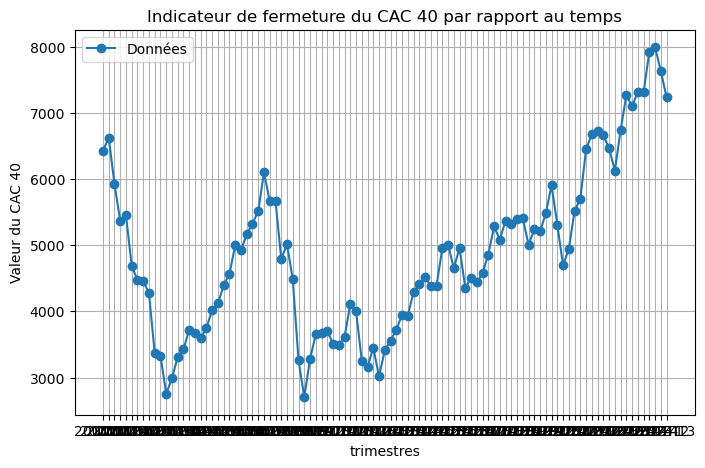

In [47]:
an.afficher_statistiques(df.Close)
an.tracer_graphique(df.Close, titre_graphique="Indicateur de fermeture du CAC 40 par rapport au temps", label_x="trimestres", label_y="Valeur du CAC 40")

### **Regression linéaire : prédiction du cac 40 à partir d'indicateurs macroéconomiques**

Première tentative de regression linéaire 

Sélection des variables dépendantes et indépendantes :

In [48]:
# Variables indépendantes : toutes les colonnes sauf les valeurs du CAC40 ( 'ev_conso_menages','ev_conso_apu')
X = df[['taux_chomage', 'indic_confiance', 'ev_pib', 'ev_importations', 
         'ev_fbcf', 'ev_exportations', 'ev_conso', 'ipc_menage']]

# Variables dépendantes (on cherche celle qui est la plus pertinente)
y = df['Close']  # ou  'High', 'Low', 'Open' selon

# On sépare les données en un ensemble d'entraînement et un ensemble de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Créer et entraîner le modèle
model = LinearRegression()
model.fit(X_train, y_train)

#Coefficients du model
print("Coefficient :", model.coef_)
print("Interception :", model.intercept_)

Coefficient : [-377.48497737   60.94177307  488.60363599  129.5320942   -70.50522452
  -76.48660803 -201.50195567  106.10821909]
Interception : -8041.932617500226


In [50]:
# Prédictions
y_pred = model.predict(X_test)

# Calcul des métriques
r2 = r2_score(y_test, y_pred)  # R² classique
n = X_test.shape[0]           # Nombre d'observations dans l'ensemble de test
p = X_test.shape[1]           # Nombre de variables explicatives

# Calcul du R² ajusté
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Résultats
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2}")
print(f"R² ajusté: {r2_adjusted}")

RMSE: 564192.4160734005
R²: 0.7084278522304166
R² ajusté: 0.496375381125265


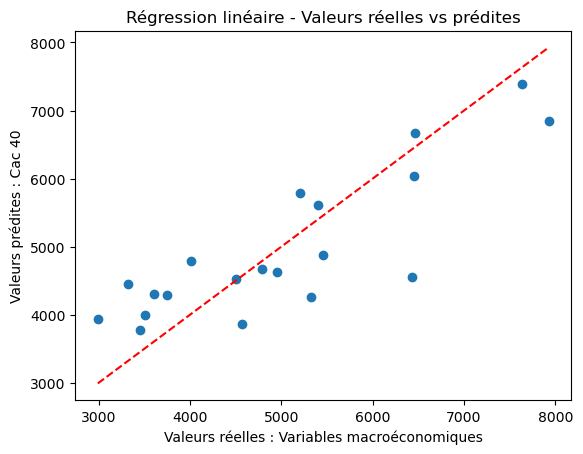

In [51]:
import matplotlib.pyplot as plt

# Affichage des valeurs réelles vs prédites
plt.scatter(y_test, y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel('Valeurs réelles : Variables macroéconomiques')
plt.ylabel('Valeurs prédites : Cac 40')
plt.title('Régression linéaire - Valeurs réelles vs prédites')
plt.show()

#### **Regression LASSO**
La regression linéaire simple n'a pas donné de résultats satifaisants. On utilise une regression lasso pour éliminer automatiquement les paramètres qui ne sont pas pertinents pour prédire le cac40.

In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error, r2_score

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Modèle de régression Lasso avec un paramètre alpha (régularisation)
alpha = 0.1  #Ce paramètre conrole la pénalisation
lasso = Lasso(alpha=alpha, random_state=42)
lasso.fit(X_train, y_train)

# Prédictions
y_pred = lasso.predict(X_test)

# Calcul des métriques
r2 = r2_score(y_test, y_pred)  # R² classique
n = X_test.shape[0]           # Nombre d'observations
p = X_test.shape[1]           # Nombre de variables explicatives

# Calcul du R² ajusté
r2_adjusted = 1 - ((1 - r2) * (n - 1) / (n - p - 1))

# Affichage des résultats
print(f"RMSE: {mean_squared_error(y_test, y_pred)}")
print(f"R²: {r2}")
print(f"R² ajusté: {r2_adjusted}")

# Affichage des coefficients Lasso
lasso_coefficients = pd.DataFrame({
    "Variable": X.columns,
    "Coefficient": lasso.coef_
})
print(lasso_coefficients[lasso_coefficients["Coefficient"] != 0])  # Variables sélectionnées


RMSE: 563879.0568222064
R²: 0.7085897949068709
R² ajusté: 0.4966551002936861
          Variable  Coefficient
0     taux_chomage  -377.385916
1  indic_confiance    60.943535
2           ev_pib   485.301948
3  ev_importations   129.302588
4          ev_fbcf   -69.877298
5  ev_exportations   -75.859896
6         ev_conso  -200.450648
7       ipc_menage   106.114041


On cherche la valeur alpha optimale (validation croisée) :

In [53]:
from sklearn.model_selection import GridSearchCV

# Définir une grille de valeurs pour alpha
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100]}
lasso_cv = GridSearchCV(Lasso(random_state=42), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Meilleur alpha et R²
best_alpha = lasso_cv.best_params_['alpha']
print(f"Meilleur alpha : {best_alpha}")
print(f"Meilleur R² en validation croisée : {lasso_cv.best_score_}")

# Réentraîner avec le meilleur alpha
lasso = Lasso(alpha=best_alpha, random_state=42)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)


Meilleur alpha : 100
Meilleur R² en validation croisée : 0.5803021546890641


/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.677e+06, tolerance: 1.005e+04
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.156e+06, tolerance: 9.460e+03
  model = cd_fast.enet_coordinate_descent(
/opt/conda/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.360e+05, tolerance: 8.322e

In [54]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

X = df.drop(columns=["Close", "trimestre"])
y = df["Close"]

# Normalisation des données
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Recherche de l'alpha optimal pour Lasso avec validation croisée
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 200]}
lasso_cv = GridSearchCV(Lasso(max_iter=5000, random_state=42), param_grid, cv=5, scoring='r2')
lasso_cv.fit(X_train, y_train)

# Meilleur alpha
best_alpha = lasso_cv.best_params_['alpha']
print(f"Meilleur alpha pour Lasso : {best_alpha}")
print(f"Meilleur R² en validation croisée : {lasso_cv.best_score_}")

# Entraînement du modèle Lasso avec le meilleur alpha
lasso = Lasso(alpha=best_alpha, max_iter=5000, random_state=42)
lasso.fit(X_train, y_train)
y_pred_lasso = lasso.predict(X_test)

# Calcul des métriques pour Lasso
r2_lasso = r2_score(y_test, y_pred_lasso)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso)
n, p = X_test.shape
r2_adjusted_lasso = 1 - ((1 - r2_lasso) * (n - 1) / (n - p - 1))

print(f"Lasso - RMSE: {rmse_lasso}")
print(f"Lasso - R²: {r2_lasso}")
print(f"Lasso - R² ajusté: {r2_adjusted_lasso}")

# Affichage des coefficients Lasso
# Affichage des coefficients Lasso
lasso_coefficients = pd.DataFrame({
    "Variable": X.columns,  # Utiliser les colonnes de X
    "Coefficient": lasso.coef_
})

print("Variables sélectionnées par Lasso :")
print(lasso_coefficients[lasso_coefficients["Coefficient"] != 0])  # Affiche uniquement les variables sélectionnées


# Tester ElasticNet en cas de convergence difficile pour Lasso
elastic_net = ElasticNet(alpha=best_alpha, l1_ratio=0.5, max_iter=5000, random_state=42)
elastic_net.fit(X_train, y_train)
y_pred_enet = elastic_net.predict(X_test)

# Calcul des métriques pour ElasticNet
r2_enet = r2_score(y_test, y_pred_enet)
rmse_enet = mean_squared_error(y_test, y_pred_enet)
r2_adjusted_enet = 1 - ((1 - r2_enet) * (n - 1) / (n - p - 1))

print(f"ElasticNet - RMSE: {rmse_enet}")
print(f"ElasticNet - R²: {r2_enet}")
print(f"ElasticNet - R² ajusté: {r2_adjusted_enet}")

# Comparaison des modèles
print("\nComparaison des performances :")
print(f"Lasso: R² = {r2_lasso}, R² ajusté = {r2_adjusted_lasso}, RMSE = {rmse_lasso}")
print(f"ElasticNet: R² = {r2_enet}, R² ajusté = {r2_adjusted_enet}, RMSE = {rmse_enet}")

# Visualisation des prédictions (facultatif)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_lasso, alpha=0.7, label="Lasso", color='blue')
plt.scatter(y_test, y_pred_enet, alpha=0.7, label="ElasticNet", color='green')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.xlabel('Variables macroéconomiques')
plt.ylabel('Cac 40')
plt.title('Cac 40 vs Variables macroéconomiques')
plt.legend()
plt.show()


KeyError: "['trimestre'] not found in axis"

L'absence de points bleu ou vert nous montrent que les regressions ne prédisent pas bien le cac40 à partir des variables macroéconomiques. Nous allons à présent tester une série temporelle. 